In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import datetime as dt
import re
from geopy.distance import vincenty
import matplotlib.dates as mdts
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, make_scorer, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from time import time
from tsfresh import extract_relevant_features, extract_features

/opt/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [57]:
accdnt_windows = pd.read_csv('../data/PeMS/Incidents/work_folder/year_accdnt_wndw.csv', parse_dates=['Timestamp'])

In [58]:
accdnt_windows['y'] = 1

In [59]:
accdnt_free_windows = pd.read_csv('../data/PeMS/Incidents/work_folder/year_accdnt_free_wndw.csv', parse_dates=['Timestamp'])

In [116]:
accdnt_free_windows['y'] = 0
accdnt_free_windows['IncidentID'] = 0

In [46]:
def plot_window(data, chrct = 'Total Flow'):
    
#     cols = [col for col in data.columns if chrct in col]
    cols = [col for col in data.index if chrct in col]
    data[cols].plot()
    plt.grid()
    plt.show()

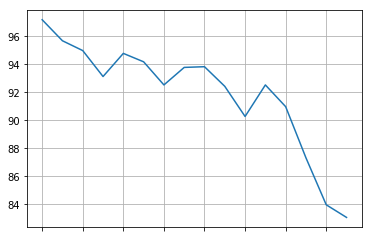

In [47]:
plot_window(accdnt_free_windows.iloc[86])

In [117]:
common_cols = ['Timestamp', 'IncidentID', 'Latitude', 'Longitude', 'Avg Occupancy_0', 'Avg Occupancy_1', 'Avg Occupancy_2',
       'Avg Occupancy_3', 'Avg Occupancy_4', 'Avg Occupancy_5',
       'Avg Occupancy_6', 'Avg Occupancy_7', 'Avg Occupancy_8',
       'Avg Occupancy_9', 'Avg Occupancy_10', 'Avg Occupancy_11',
       'Avg Occupancy_12', 'Avg Occupancy_13', 'Avg Occupancy_14',
       'Avg Occupancy_15', 'Avg Speed_0', 'Avg Speed_1', 'Avg Speed_2',
       'Avg Speed_3', 'Avg Speed_4', 'Avg Speed_5', 'Avg Speed_6',
       'Avg Speed_7', 'Avg Speed_8', 'Avg Speed_9', 'Avg Speed_10',
       'Avg Speed_11', 'Avg Speed_12', 'Avg Speed_13', 'Avg Speed_14',
       'Avg Speed_15', 'Total Flow_0', 'Total Flow_1', 'Total Flow_2',
       'Total Flow_3', 'Total Flow_4', 'Total Flow_5', 'Total Flow_6',
       'Total Flow_7', 'Total Flow_8', 'Total Flow_9', 'Total Flow_10',
       'Total Flow_11', 'Total Flow_12', 'Total Flow_13', 'Total Flow_14',
       'Total Flow_15', 'y']

In [203]:
dataset = pd.concat((accdnt_windows[common_cols], accdnt_free_windows[common_cols]), axis=0)

In [14]:
weather = pd.read_csv('../data/Weather/weather.csv', parse_dates=["Date"])

In [32]:
weather['Date'] = weather.Date.dt.date

In [204]:
dataset['Date'] = dataset.Timestamp.dt.date

In [205]:
dataset = dataset.merge(weather, how='left', on='Date').drop(columns='Date')

In [206]:
dataset['Hour'] = dataset.Timestamp.dt.hour

In [207]:
dataset = dataset.drop(index=dataset[(dataset['Hour']<6) | (dataset['Hour']>21)].index).reset_index(drop=True)

In [208]:
dataset = pd.get_dummies(dataset, columns=['Hour'], prefix='hour_')

In [209]:
np.random.seed(442)
dataset = dataset.loc[np.random.choice(dataset.shape[0], dataset.shape[0], replace=False)]

In [210]:
dataset.reset_index(drop=True, inplace=True)

In [127]:
non_series_cols = [col for col in dataset.columns if 'Avg' not in col and 'Total' not in col]

In [129]:
dataset.to_csv('../data/PeMS/Incidents/work_folder/windows.csv', index=False)

In [40]:
dataset= pd.read_csv('../data/PeMS/Incidents/work_folder/windows.csv')

In [96]:
def feature_extraction(dataset):
    cols = [col for col in dataset.columns if 'Avg' in col or 'Total' in col]
    dataset = dataset[cols]
    t_labels = np.arange(len(cols)/3, dtype=int)
    t_labels = np.concatenate((t_labels,t_labels,t_labels))
    aux_labels = pd.DataFrame({'val_name': cols, 't': t_labels})
    long = dataset.reset_index().melt(id_vars=['index'], var_name='series_param', value_name='value')
    long = long.merge(aux_labels, how='left', left_on='series_param', right_on='val_name').drop('val_name', axis=1)
    long['series_param'] = long['series_param'].apply(lambda row: row.split('_')[0])
    long = long.rename(columns={'index': 'ID'})[['ID', 't', 'series_param', 'value']]
    extracted = extract_features(long, column_id='ID', column_sort='t', column_kind='series_param', column_value='value', n_jobs=4)
    # try imputation
    extracted.dropna(axis=1, how='any', inplace=True)
    return extracted

In [97]:
def batch_extraction(dataset, b_size):
    m=dataset.shape[0]
    result=pd.DataFrame()
    for i in range(0, m, b_size):
        crnt_ftrs = feature_extraction(dataset.loc[i:i+b_size-1])
#         result = pd.concat((result, crnt_ftrs))
        crnt_ftrs.to_csv('../data/PeMS/Incidents/work_folder/extracted/extracted_{0:d}.csv'.format(i), index=False)
    print('EGOR virubajjj!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')


In [112]:
batch_extraction(dataset, 1000)

Feature Extraction: 100%|██████████| 20/20 [01:18<00:00,  3.92s/it]


EGOR virubajjj!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [129]:
tr_X, te_X, tr_y, te_y = train_test_split(test.drop(columns=['y']), test['y'], stratify=test.y, test_size=.2)

In [236]:
logreg = LogisticRegression()
logreg.fit(tr_X, tr_y)
print('acc =', logreg.score(te_X, te_y))
predict = logreg.predict(te_X)
F1_score = f1_score(te_y, predict)
print('f1 =', F1_score)
print('CM =', confusion_matrix(te_y, predict))

acc = 0.6635275652344517
f1 = 0.6567940764458675
CM = [[3482 1431]
 [1999 3282]]


In [237]:
forest = RandomForestClassifier(random_state=14)
forest.fit(tr_X, tr_y)
print('acc =', forest.score(te_X, te_y))
predict = forest.predict(te_X)
F1_score = f1_score(te_y, predict)
print('f1 =', F1_score)
print('CM =', confusion_matrix(te_y, predict, labels=[0,1]))

acc = 0.7032568177359231
f1 = 0.6977720051953242
CM = [[3677 1236]
 [1789 3492]]


In [238]:
proba = forest.predict_proba(te_X)

In [239]:
fpr, tpr, _ = roc_curve(te_y, proba[:,1])

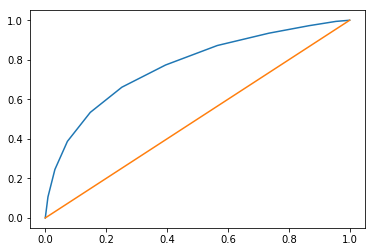

In [240]:
plt.plot(fpr, tpr)
plt.plot([0, 1],[0,1])
plt.show()

In [159]:
def batch_concatenation(dataset, b_size):
    m=dataset.shape[0]
    result = pd.DataFrame()
    for i in range(0, m, b_size):
        crnt_ftrs = pd.read_csv('../data/PeMS/Incidents/work_folder/extracted/extracted_{0:d}.csv'.format(i))
        crnt_ftrs = crnt_ftrs.replace([np.inf, -np.inf], np.NaN)
        crnt_ftrs.dropna(axis=1, inplace=True)
        result = pd.concat((result, crnt_ftrs), axis=0)
    result = result.dropna(axis=1).reset_index(drop=True)
    non_series_cols = [col for col in dataset.columns if 'Avg' not in col and 'Total' not in col]
    result = pd.concat((result, dataset[non_series_cols]), axis=1)
    return result

In [160]:
test = batch_concatenation(dataset,1000)

In [168]:
test.drop(columns='Timestamp', inplace=True)

In [172]:
tr_X, te_X, tr_y, te_y = train_test_split(test.drop(columns=['y', 'IncidentID']), test['y'], stratify=test.y)

In [173]:
scaler = StandardScaler()

In [174]:
tr_X = scaler.fit_transform(tr_X)

In [175]:
te_X = scaler.transform(te_X)

In [176]:
logreg = LogisticRegression()
logreg.fit(tr_X, tr_y)
print('acc =', logreg.score(te_X, te_y))
predict = logreg.predict(te_X)
F1_score = f1_score(te_y, predict)
print('f1 =', F1_score)
print('CM =', confusion_matrix(te_y, predict))

acc = 0.6727486756915833
f1 = 0.6631663974151858
CM = [[3574 1339]
 [1997 3284]]


In [177]:
forest = RandomForestClassifier(random_state=14)
forest.fit(tr_X, tr_y)
print('acc =', forest.score(te_X, te_y))
predict = forest.predict(te_X)
F1_score = f1_score(te_y, predict)
print('f1 =', F1_score)
print('CM =', confusion_matrix(te_y, predict, labels=[0,1]))

acc = 0.6917794781243869
f1 = 0.6789290823625587
CM = [[3730 1183]
 [1959 3322]]


In [211]:
dataset.drop(columns='Timestamp', inplace=True)

In [230]:
tr_X, te_X, tr_y, te_y = train_test_split(dataset.drop(columns=['y', 'IncidentID']), dataset['y'], stratify=dataset.y)

In [231]:
scaler = StandardScaler()

In [232]:
tr_X = scaler.fit_transform(tr_X)

In [233]:
te_X = scaler.transform(te_X)

In [234]:
logreg = LogisticRegression()
logreg.fit(tr_X, tr_y)
print('acc =', logreg.score(te_X, te_y))
predict = logreg.predict(te_X)
F1_score = f1_score(te_y, predict)
print('f1 =', F1_score)
print('CM =', confusion_matrix(te_y, predict))

acc = 0.6635275652344517
f1 = 0.6567940764458675
CM = [[3482 1431]
 [1999 3282]]


In [235]:
forest = RandomForestClassifier(random_state=14)
forest.fit(tr_X, tr_y)
print('acc =', forest.score(te_X, te_y))
predict = forest.predict(te_X)
F1_score = f1_score(te_y, predict)
print('f1 =', F1_score)
print('CM =', confusion_matrix(te_y, predict, labels=[0,1]))

acc = 0.7032568177359231
f1 = 0.6977720051953242
CM = [[3677 1236]
 [1789 3492]]


In [263]:
grid_params = {'n_estimators': [10, 100, 200],
               'max_depth' : [2, 3, 5],  
               'min_samples_leaf': [2, 5, 10]
}
grd_search = GridSearchCV(forest, grid_params,
                          scoring={'f1_score' : make_scorer(f1_score)},
                          refit='f1_score',
                          cv=5, return_train_score=True, n_jobs=-1, verbose=2)

In [264]:
grd_search.fit(tr_X, tr_y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] max_depth=2, min_samples_leaf=2, n_estimators=10 ................
[CV] max_depth=2, min_samples_leaf=2, n_estimators=10 ................
[CV] max_depth=2, min_samples_leaf=2, n_estimators=10 ................
[CV] max_depth=2, min_samples_leaf=2, n_estimators=10 ................
[CV] . max_depth=2, min_samples_leaf=2, n_estimators=10, total=   3.1s
[CV] max_depth=2, min_samples_leaf=2, n_estimators=10 ................
[CV] . max_depth=2, min_samples_leaf=2, n_estimators=10, total=   3.0s
[CV] . max_depth=2, min_samples_leaf=2, n_estimators=10, total=   3.0s
[CV] . max_depth=2, min_samples_leaf=2, n_estimators=10, total=   3.1s
[CV] max_depth=2, min_samples_leaf=2, n_estimators=100 ...............
[CV] max_depth=2, min_samples_leaf=2, n_estimators=100 ...............
[CV] max_depth=2, min_samples_leaf=2, n_estimators=100 ...............
[CV] . max_depth=2, min_samples_leaf=2, n_estimators=10, total=   0.4s
[CV] max_depth=

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.3s


[CV]  max_depth=2, min_samples_leaf=5, n_estimators=200, total=   6.7s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=100 ..............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=100, total=   3.6s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=100 ..............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=100, total=   3.7s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=100 ..............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=100, total=   3.9s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=200 ..............
[CV]  max_depth=2, min_samples_leaf=5, n_estimators=200, total=   7.0s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=200 ..............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=100, total=   3.1s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=200 ..............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=100, total=   3.3s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=200 ..............
[

[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  3.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=14, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 100, 200], 'max_depth': [2, 3, 5], 'min_samples_leaf': [2, 5, 10]},
       pre_dispatch='2*n_jobs', refit='f1_score', return_train_score=True,
       scoring={'f1_score': make_scorer(f1_score)}, verbose=2)

In [265]:
grd_search.best_score_

0.5738945649022463

In [246]:
dataset[dataset.y==1].shape

(21125, 72)